In [1]:
import os
import sys

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

    # Clone or update repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    IN_COLAB = False
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

IN COLAB
Already up to date.
Processing ./smart-stock-rl
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for smart-stock: filename=smart_stock-0.0.1-py3-none-any.whl size=22773 sha256=4f20aacf7a356f777acafaec1a788ae6009580bb382ecbd3fe2cd174c1632153
  Stored in directory: /root/.cache/pip/wheels/5f/9a/51/d85d16e6e8cc024031e89ea4d0070e740e1d0cbc121406bacf
Successfully built smart-stock
  Attempting uninstall: smart-stock
    Found existing installation: smart-stock 0.0.1
    Uninstalling smart-stock-0.0.1:


In [3]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [4]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

## Dataset

In [5]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ.get("KAGGLE_USERNAME",None) is None and os.environ.get("KAGGLE_USERNAME",None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Kaggle Username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:    
        api_key = getpass.getpass(prompt="Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key

    # In Google Colab preserve the login auth across environment restarts.
    if IN_COLAB:
        !mkdir -p ~/.kaggle/
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
            json.dump({'username':os.environ["KAGGLE_USERNAME"], 'key':os.environ["KAGGLE_KEY"]}, f)

In [6]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)

# This command will download the dataset if it does not exist on the system.
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [7]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [8]:
def train(
    agent,
    max_episodes: int = 1000,
    **kwargs,
    ) -> tuple[list[float], bool]:
    """Generic agent training method.

    Specific methods should wrap this one and pass agent-specific arguments
    as keyword arguments.
    """
    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = agent.run_episode(**kwargs)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

In [9]:
def train_QSFM(
    agent: ss.algorithms.qlearning.qsfm.QSFM, 
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train QSFM agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps,
        render=render,
        render_mode=render_mode,
        )

In [10]:
def train_DQN(
    agent: ss.algorithms.deepq.dqn.DQN, 
    max_episodes: int = 1000,
    max_steps: int = None,
    target_update_freq: int = 10,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train DQN agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps, 
        target_update_freq=target_update_freq,
        render=render, 
        render_mode=render_mode,
        )

## Environment

In [11]:
# Create stock environment using specific stock.
df = dataset['aapl']
start_balance = 10000
max_stock = 10 # 1 # 100
start_day = None
env_name = 'StockDataEnv'
env = ss.envs.StockDataEnv(
    df=df, 
    start_balance=start_balance, 
    max_stock=max_stock, 
    start_day=start_day,
)

In [12]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    env.seed(RANDOM_SEED)
    env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [13]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.01 # Step size.
epsilon = 0.2 # Epsilon-greedy action selection (should be in (0,1)).
batch_size = 32
memory_capacity = 1000
target_update_freq = 10
render = False
render_mode = 'csv'

# Set PyTorch device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# Setup DQN policy.
n_actions = len(np.arange(env.action_space.low, env.action_space.high+1))
dims = [
    env.observation_space.shape[0],
    512,
    n_actions
]
policy = ss.algorithms.deepq.policies.FeedForwardLinearPolicy(
    env.action_space,
    env.observation_space,
    epsilon,
    device,
    dims,
    )

# Configure PyTorch optimizer and loss criterion.
optimizer = torch.optim.SGD(policy.policy_net.parameters(), lr=alpha)
criterion = torch.nn.SmoothL1Loss()

# Build agent.
agent = ss.algorithms.deepq.dqn.DQN(
    env, 
    policy, 
    gamma, 
    alpha, 
    memory_capacity, 
    batch_size,
    optimizer,
    criterion
)

device: cuda


[0] 5.238384043798534
[1] 4.354283491052101
[2] 4.438084946472372
[3] 5.035565076163039
[4] 4.754965276981238
[5] -10.868271803276912
[6] -180.25196311910258
[7] 4.953696844296636
[8] 4.899533580175678
[9] -16.55438820598556
[10] 5.15662643338189
[11] 4.240761615045244
[12] -3.317671794056565
[13] 10.687026093129816
[14] 4.575000136072049
[15] 4.47949302171827
[16] 4.342320304396536
[17] 4.874211025424302
[18] 4.959286680794321
[19] 6.9757613186007035
[20] 7.614173341406513
[21] 1.2073890046723932
[22] 2.9867311164718444
[23] 4.582019947500696
[24] 4.3112755391021365
[25] 7.929255746208071
[26] 5.380930852196343
[27] 3.4461494098814
[28] 7.668489478221687
[29] 14.13857328039477
[30] 4.829447555122897
[31] 5.0581797588624795
[32] 5.058114868927987
[33] 5.016301193588917
[34] 3.0067552438995335
[35] 6.043490972857629
[36] 4.724922017368954
[37] -12.795244671306136
[38] 4.69921071713452
[39] 5.208053769148308
[40] -12.589592312761852
[41] -49.79587482564966
[42] 5.348150345023896
[43] 0.0

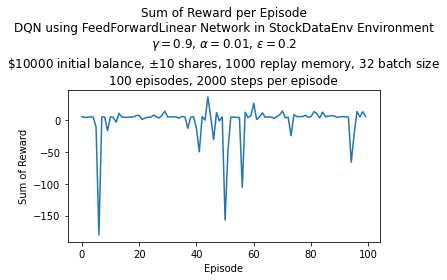

In [14]:
max_episodes = 100 # 1000 # Upper-limit on number of possible episodes.
max_steps = 2000
render = False
render_mode = 'csv'

# Train the agent 
with timecontextprint():
    rewards, found_soln = train_DQN(
        agent, 
        max_episodes, 
        max_steps,
        target_update_freq, 
        render, 
        render_mode,
    )

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nDQN using FeedForwardLinear Network in {env_name} Environment\n$\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$\n\${start_balance} initial balance, $\pm${max_stock} shares, {memory_capacity} replay memory, {batch_size} batch size\n{max_episodes} episodes, {max_steps} steps per episode")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()